# Homework 2 Part 2

This is an individual assignment.

---

Write your own code. You may repurpose any functions built during lecture.

---

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix

---

# Problem 1 (25 points)

**In this problem you will be working with the [handwritten digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) from ```scikit-learn```. The dataset contains 1797 samples. Each sample is a 64-dimensional vector representing all pixels of a $8\times 8$ grayscale image of a handwritten digit. There are a total of 10 digits (10 targets) and about 180 images per digit. Let's load the data:**

In [2]:
from sklearn.datasets import load_digits

digits = load_digits(return_X_y=False)

print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
X = digits.data # training data
t = digits.target # target values

X.shape, t.shape

((1797, 64), (1797,))

**Each image can be reshaped as a $8\times 8$ grayscale image and plotted:**

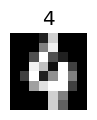

In [6]:
img_no = 100

plt.figure(figsize=(1,1))
plt.imshow(X[img_no,:].reshape(8,8), cmap='gray')
plt.title(t[img_no]) # insert title with the label
plt.axis('off');

**Here's some image examples from all 10 classes:**

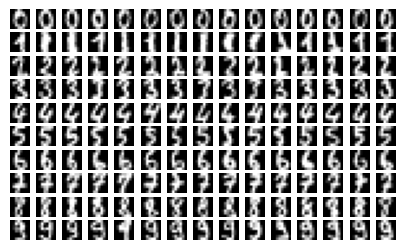

In [7]:
plt.figure(figsize=(5,3))
grid=1
for j in range(10):
    loc = np.where(t==j)[0]
    idx_rd = np.random.choice(loc,15,replace=False)
    for i in range(15):
        plt.subplot(10,15,grid)
        plt.imshow(X[idx_rd[i],:].reshape(8,8), cmap='gray')
        plt.axis('off')
        grid+=1

**Build a Bayesian classifier to perform classification on this dataset. Start by partitioning the data into 80% training set and 20% test set (fix the ```random_state``` to allow for reproducibility). Report performance on test set.**

1. (10 points) **Assume that each class is modeled according to a multivariate Gaussian distribution, $P(\mathbf{x}|C_i)\sim G(\mu_i,\Sigma_i)$. Use MLE approach to estimate the parameters of the data likelihoods. Use your estimated density functions to generate new samples (5 samples) and plot them.**

2. (15 points) **Use the parzen-window density approach with a Gaussian kernel to estimate the data likelihoods. Carry experimental design to determine the best value for the kernel *bandwidth*. Use your estimated density functions to generate new samples (5 samples) and plot them.**

**For each density estimation approach:**
* **Do the new samples _look_ as expected?**
* **What can you do to improve the results?**

In [53]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2,
                                                    stratify=t,
                                                    random_state=0)

X_train.shape, X_test.shape, t_train.shape, t_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [94]:
priors = np.array([sum(t_train==i)/len(t_train) for i in range(10)])
priors

array([0.09881698, 0.10160056, 0.09881698, 0.10160056, 0.10090466,
       0.10090466, 0.10090466, 0.09951287, 0.0967293 , 0.10020877])

In [96]:
def generate_samples_MLE(X, c, figsize, s=8, n=5):
    
    # Parameter estimation with MLE are simply the data averages
    mu  = np.mean(X, axis=0) # sample mean
    sig = np.cov(X.T) # sample covariance
    
    # Create a Gaussian PDF from these estimations
    G = stats.multivariate_normal(mean=mu, cov=sig, allow_singular=True)
    
    # Sample points from this density
    new_samples = G.rvs(size=n)
    
    # Plot them
    if figsize!=0:
        # Printing which class we are working with
        print('Generating samples from class: ', c)
        
        plt.figure(figsize=figsize)
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(new_samples[i,:].reshape(s,s), cmap='gray')
            plt.axis('off')
        plt.show()
    
    return G

In [97]:
def Bayesian_classifier(X_train, X_test, t_train, t_test, priors, approach):
    
    c = len(priors)
    N = X_test.shape[0]
    
    pos = []
    prediction = []
    for i in range(N):
        sample_pos = []
        for j in range(c):
            if approach[0]==1: #MLE
                sample_pos += [priors[j]*generate_samples_MLE(X_train[t_train==j,:], j, 0).pdf(X_test[i,:])]
            elif approach[0]==2: #KDE
                sample_pos += [priors[j]*generate_samples_KDE(X_train[t_train==j,:], 
                                                              approach[1], j, 0).pdf(X_test[i,:])]
        prediction += [np.argmax(sample_pos)]
        pos += [np.max(sample_pos)]
        
    return np.array(prediction), np.array(pos)

In [99]:
y_test,_=Bayesian_classifier(X_train, X_test, t_train, t_test, priors, [1])
accuracy_score(t_test, y_test)

0.9416666666666667

Generating samples from class:  0


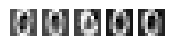

Generating samples from class:  1


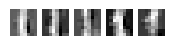

Generating samples from class:  2


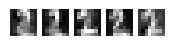

Generating samples from class:  3


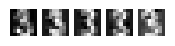

Generating samples from class:  4


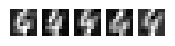

Generating samples from class:  5


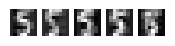

Generating samples from class:  6


Generating samples from class:  7


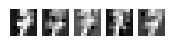

Generating samples from class:  8


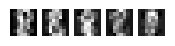

Generating samples from class:  9


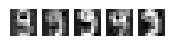

In [100]:
for label in range(10):
    generate_samples_MLE(X_train[t_train==label,:], label, figsize=(2,1), s=8, n=5)

In general, the generated samples look like the intended class but there is a lot of smoothness at the boundariesthe digit/s, specially if the the digit can draw in many different ways (such as 8 and 9). For digits that do not vary significantly in the way they are drawn (like digit 0), the generated samples are much *closer* to their expected shape.

Moreover, the assumption that each class is drawn from a multivariate Gaussian (a unimodal distribution) may not be appropriate. We can choose other well-defined distributions or consider a mixture model (sum of weighted distributions). Both these cases are parametric density estimation. Another approach are under non-parametric density functions such as kernel density estimation (or parzen-window density function).

In [101]:
def generate_samples_KDE(X, h1, c, figsize, s=8, n=5):
    
    # KDE with Gaussian kernel with bandwidth h1
    try:
        G = stats.gaussian_kde(X.T, bw_method=h1)
    except:
        eps = 10**-4*np.random.randn(X.shape[0], X.shape[1])
        G = stats.gaussian_kde((X + eps).T , bw_method=h1)
    
    # Sample points from this density
    new_samples = G.resample(size=n)
    
    # Plot them
    if figsize!=0:
        # Printing which class we are working with
        print('Generating samples from class: ', c)
        
        plt.figure(figsize=figsize)
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(new_samples[:,i].reshape(s,s), cmap='gray')
            plt.axis('off')
        plt.show()
    
    return G

In [104]:
# 2) Experimental Design

# K-fold CV
k=4
kf = KFold(n_splits=k, shuffle=True, random_state=0)

# Set possible values for h1
h1_vals = [0.1,0.2,0.5,0.8,1,1.5]

perf_train = np.zeros(len(h1_vals))
perf_val   = np.zeros(len(h1_vals))

perf_best  = 0
h1_best    = 0

for i in range(len(h1_vals)):  
    h1   = h1_vals[i]
    print('h1 value = ',h1)

    # For each training/validation split
    f=1

    #initialize performance measures
    perf_train_avg, perf_val_avg = 0, 0

    for train_index, validation_index in kf.split(X_train):
        print('\nFold ',f)

        # Select training set using the indices found from kf.split
        x_train2, x_validation = X_train[train_index], X_train[validation_index]

        # Select validation set using the indices found from kf.split
        t_train2, t_validation = t_train[train_index], t_train[validation_index]
        
        # priors for each subset
        priors2 = np.array([sum(t_train2==i)/len(t_train2) for i in range(10)])

        # Training model with training set
        y_train2,_=Bayesian_classifier(x_train2, x_train2, t_train2, t_train2, priors2, [2,h1])

        # Evaluate trained model in validation set
        y_validation,_=Bayesian_classifier(x_train2, x_validation, t_train2, t_validation, priors2, [2,h1])

        # Performance Measure
        perf_train[i] = accuracy_score(t_train2, y_train2)
        perf_val[i]   = accuracy_score(t_validation, y_validation)

        # Average performance measure
        perf_train_avg = perf_train_avg + perf_train[i]
        perf_val_avg = perf_val_avg + perf_val[i]
        print('Performance Training = ', perf_train[i])
        print('Performance Validation = ', perf_val[i])
        f+=1

    print('\nAverage Performance in Training = ', perf_train_avg/k)
    print('Average Performance in Validation = ', perf_val_avg/k)
    if perf_val_avg/k > perf_best:
        perf_best = perf_val_avg/k
        h1_best   = h1
    print('-----------------------------------------------------\n')
print('best h1 = ', h1_best)

h1 value =  0.1

Fold  1
Performance Training =  0.17920148560817084
Performance Validation =  0.07777777777777778

Fold  2
Performance Training =  0.1836734693877551
Performance Validation =  0.08913649025069638

Fold  3
Performance Training =  0.20315398886827457
Performance Validation =  0.11142061281337047

Fold  4
Performance Training =  0.16883116883116883
Performance Validation =  0.116991643454039

Average Performance in Training =  0.18371502817384233
Average Performance in Validation =  0.0988316310739709
-----------------------------------------------------

h1 value =  0.2

Fold  1
Performance Training =  0.9870009285051068
Performance Validation =  0.09444444444444444

Fold  2
Performance Training =  0.9758812615955473
Performance Validation =  0.1392757660167131

Fold  3
Performance Training =  0.9730983302411874
Performance Validation =  0.14763231197771587

Fold  4
Performance Training =  0.974025974025974
Performance Validation =  0.15598885793871867

Average Performan

Based on these results, the value $h_1=0.5$ reports the highest accuracy in the validation set. We now estimate the final density and train the Bayesian classifier using the entire training dataset for this value of $h_1$.

In [105]:
print('Best h1=',h1_best)
y_test,_=Bayesian_classifier(X_train, X_test, t_train, t_test, priors, [2, h1_best])
accuracy_score(t_test, y_test)

Best h1= 0.8


0.9444444444444444

Generating samples from class:  0


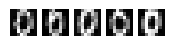

Generating samples from class:  1


Generating samples from class:  2


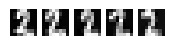

Generating samples from class:  3


Generating samples from class:  4


Generating samples from class:  5


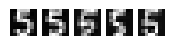

Generating samples from class:  6


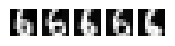

Generating samples from class:  7


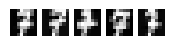

Generating samples from class:  8


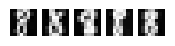

Generating samples from class:  9


In [106]:
for label in range(10):
    generate_samples_KDE(X_train[t_train==label,:], 0.1, label, figsize=(2,1), s=8, n=5)

---

# Problem 2 (20 points)

**In this problem you will be working with the [MovieLens-100k dataset](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset/download?datasetVersionNumber=1).**

**Build a content-based recommender system using collaborative filtering with the alternating least squares (ALS) optimization algorithm.**

**Implement your code based on lecture notes. To successfully answer this problem, you do not have to exhaustively search for $k$ and $\lambda$. Select values for these hyperparameters, train the model. Use your prediction matrix $Y$ to recommend movies with predicted rating at 4.5 stars or higher.**

In [2]:
#Import datasets
moviesRaw = pd.read_csv('MovieLens 10k/movies.csv')
ratingsRaw= pd.read_csv('MovieLens 10k/ratings.csv')

# Merge Movies and Tags
all_movies = pd.merge(moviesRaw, ratingsRaw, left_on='movieId', right_on='movieId', how='inner')
all_movies_grouped = all_movies.groupby('userId')
all_movies

movieId                                      title  \
0             1                           Toy Story (1995)   
1             1                           Toy Story (1995)   
2             1                           Toy Story (1995)   
3             1                           Toy Story (1995)   
4             1                           Toy Story (1995)   
...         ...                                        ...   
100831   193581  Black Butler: Book of the Atlantic (2017)   
100832   193583               No Game No Life: Zero (2017)   
100833   193585                               Flint (2017)   
100834   193587        Bungo Stray Dogs: Dead Apple (2018)   
100835   193609        Andrew Dice Clay: Dice Rules (1991)   

                                             genres  userId  rating  \
0       Adventure|Animation|Children|Comedy|Fantasy       1     4.0   
1       Adventure|Animation|Children|Comedy|Fantasy       5     4.0   
2       Adventure|Animation|Children|Comedy|Fantasy       7     4.5   
3       Adventure|Animation|Children|Comedy|Fantasy      15     2.5   
4       Adventure|Animation|Children|Comedy|Fantasy      17     4.5   
...                                             ...     ...     ...   
100831              Action|Animation|Comedy|Fantasy     184     4.0   
100832                     Animation|Comedy|Fantasy     184     3.5   
100833                                        Drama     184     3.5   
100834                             Action|Animation     184     3.5   
100835                                       Comedy     331     4.0   

         timestamp  
0        964982703  
1        847434962  
2       1106635946  
3       1510577970  
4       1305696483  
...            ...  
100831  1537109082  
100832  1537109545  
100833  1537109805  
100834  1537110021  
100835  1537157606  

[100836 rows x 6 columns]

In [3]:
# Number of movies in the database

N_movies = all_movies['movieId'].nunique()

N_movies

9724

Movie IDs do not follow a continuous integer range. For that reason, let's find the unique movie ids and work off of their index location in subsequent steps:

In [61]:
movie_ids = np.sort(all_movies['movieId'].unique())

In [62]:
# Number of users

N_users = all_movies['userId'].nunique()
N_users

610

Similarly, the user IDs in the database are as follows:

In [63]:
user_ids  = np.sort(all_movies['userId'].unique())

Now, let's create the rating matrix $X$. I will treat any movie that was not rated with a 0.

In [64]:
# Ratings matrix (N_users x N_movies)

# Assumes non-rated movies have entrie "0"
X = np.zeros((len(user_ids), N_movies))

movies_per_user = {}
for i in range(N_users):
    # identify which movies user i rated
    rated_movies = all_movies[all_movies['userId'] == user_ids[i]]['movieId'].values
    mov_loc = np.where(movie_ids==rated_movies.reshape(-1,1))[1]
    # retrieve the respective rating values
    ratings = all_movies[all_movies['userId'] == user_ids[i]]['rating'].values
    # assign them to specific location in the ratings matrix
    X[i,mov_loc] = ratings
    # dictionary that contains a list of all index locations for movies rated by user i
    movies_per_user[i] = mov_loc

In [65]:
X

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [66]:
X.shape

(610, 9724)

In [67]:
# index locations for movies watched by user ID

ID = 100
movies_per_user[ID]

array([ 190,  199,  316,  328,  620,  831,  855,  910, 1289, 1724, 1741,
       1790, 1795, 1796, 1831, 1871, 1873, 1882, 1915, 1930, 1945, 1958,
       1959, 1960, 2013, 2019, 2021, 2027, 2029, 2030, 2031, 2035, 2037,
       2042, 2043, 2077, 2083, 2134, 2144, 2189, 2224, 2257, 2262, 2324,
       2379, 2380, 2390, 2391, 2395, 2410, 2419, 2466, 2473, 2531, 2670,
       2696, 2775, 2802, 2803, 2822, 2832])

On average, each user rates:  165.0  movies


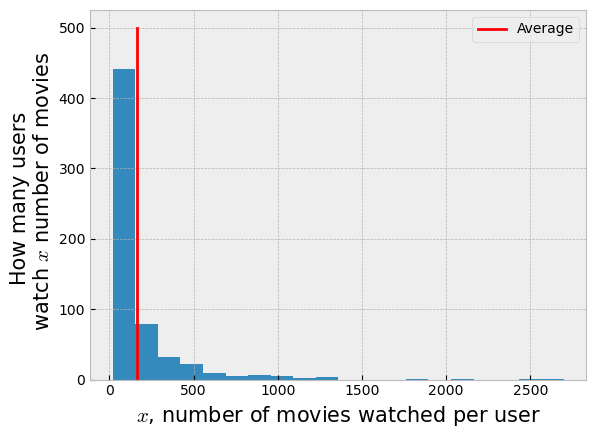

In [72]:
movies_watched = np.array([len(movies_per_user[i]) for i in range(N_users)])

print('On average, each user rates: ', np.floor(np.mean(movies_watched)), ' movies')
plt.hist(movies_watched, bins=20)
plt.plot(np.floor(np.mean(movies_watched))*np.ones(100), np.linspace(0,500,100), 'r', label='Average')
plt.xlabel('$x$, number of movies watched per user', size=15)
plt.ylabel('How many users \n watch $x$ number of movies', size=15)
plt.legend();

I will now also create a dictionary that will store all user IDs that rated movie $j$.

In [75]:
users_per_movie = {}
for j in range(N_movies):
    user_watchers = all_movies[all_movies['movieId'] == movie_ids[j]]['userId'].values
    user_loc = np.where(user_ids==user_watchers.reshape(-1,1))[1]
    users_per_movie[j] = user_loc

In [76]:
# index locations for user IDs that watched movie IDm

IDm = 100
users_per_movie[IDm]

array([  5,  83, 178])

On average, each movie is rated by :  10.0  users


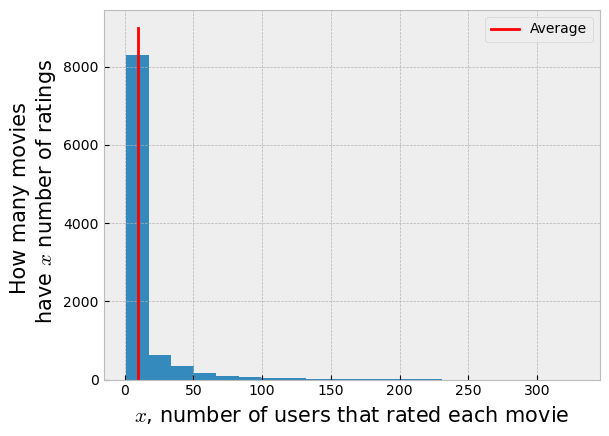

In [80]:
users_watched_movie_j = np.array([len(users_per_movie[j]) for j in range(N_movies)])

print('On average, each movie is rated by : ', np.floor(np.mean(users_watched_movie_j)), ' users')
plt.hist(users_watched_movie_j, bins=20)
plt.plot(np.floor(np.mean(users_watched_movie_j))*np.ones(100), np.linspace(0,9000,100), 'r', label='Average')
plt.xlabel('$x$, number of users that rated each movie', size=15)
plt.ylabel('How many movies \n have $x$ number of ratings', size=15)
plt.legend();

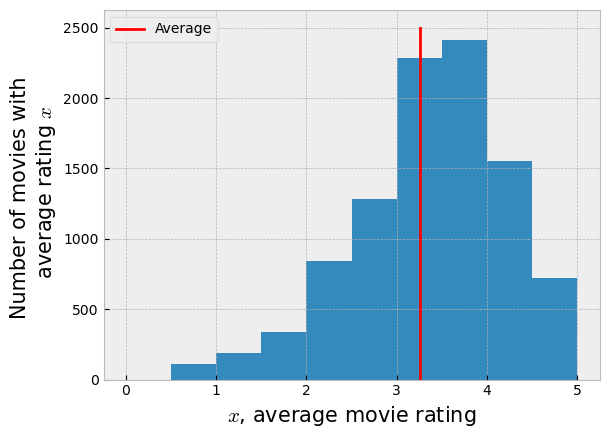

In [107]:
# average rating per movie

avg_ratings = np.array([np.mean(all_movies['rating'][all_movies['movieId']==movie_ids[j]]) 
                        for j in range(N_movies)])

plt.hist(avg_ratings, bins=np.arange(0,5.5,0.5))
plt.plot(np.ones(100)*np.mean(avg_ratings), np.linspace(0,2500,100),'r',label='Average')
plt.xlabel('$x$, average movie rating',size=15)
plt.ylabel('Number of movies with \n average rating $x$', size=15)
plt.legend();

---

## Collaborative Filtering with Alternating Least Squares (ALS)

Starting of the ALS algorithm for Collaborative Filtering.

In [181]:
# Hyperparameters
k   = 10       # latent space hyperparameter
lam = 2        # regularization hyperparameter
nIter = 101    # maximum number of iterations (convergence criterion)
thres = 0.1    # threshold for error (convergence criterion)

#initializations
V   = np.random.rand(N_movies, k)             # V is N_movies-by-k
V   = np.hstack((np.ones((N_movies,1)), V))   # appending column of ones associated with offset parameter b_V
epoch = 0                                     # iteration t=0
error = 10**10                                # setting initial error very large
U = np.zeros((N_users,k))                     # initializing U to be replaced with entries under for loop on i below
U = np.hstack((np.ones((N_users,1)), U))      # appending column of ones associated with offset b_U

# starting training with ALS optimization
while error>thres and epoch<nIter:
    # Update U
    for i in range(N_users):
        movies_rated_by_i = movies_per_user[i]       # find index locations for movies rated by user i
        t = X[i,movies_rated_by_i]                   # obtain associated rating numerical values
        # Least squares solution for Ui
        U[i,:] = np.linalg.inv(V[movies_rated_by_i,:].T@V[movies_rated_by_i,:] + 
                               lam*np.eye(k+1))@V[movies_rated_by_i,:].T@t
    
    # Update V
    for j in range(N_movies):
        users_rated_mov_j = users_per_movie[j]       # find index locations for users that rated movie j
        t = X[users_rated_mov_j,j]                   # obtain respective rating numerical values
        # Least squares solution for Vj
        V[j,:] = np.linalg.inv(U[users_rated_mov_j,:].T@U[users_rated_mov_j,:] + 
                               lam*np.eye(k+1))@U[users_rated_mov_j,:].T@t
    
    # Prediction
    Y = U@V.T
    
    # Evaluate performance on data that exists in the dictionary
    mse=0
    for i in range(N_users):
        mse+=sum((X[i,movies_per_user[i]]-
                  Y[i,movies_per_user[i]])**2)/len(movies_per_user[i])   # compare predictions with ground truth
    error = mse/N_users                                                  # normalize by number of movies watched
    if epoch % 10 == 0:
        print('Iteration:',epoch,', MSE: ', error)
    epoch+=1

Iteration: 0 , MSE:  0.5659330124732225
Iteration: 10 , MSE:  0.347781920793977
Iteration: 20 , MSE:  0.34535898947352045
Iteration: 30 , MSE:  0.3434803587938211
Iteration: 40 , MSE:  0.3421467552184509
Iteration: 50 , MSE:  0.34054412510737797
Iteration: 60 , MSE:  0.33931525048746286
Iteration: 70 , MSE:  0.3384630511067306
Iteration: 80 , MSE:  0.3378059776928823
Iteration: 90 , MSE:  0.33723865159735933
Iteration: 100 , MSE:  0.3366692053510877


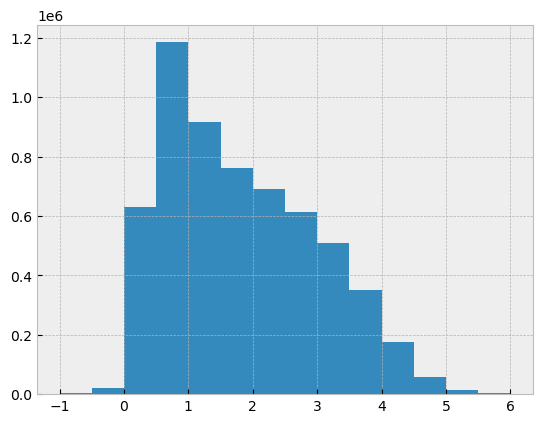

In [182]:
# Recommendation predictions

plt.hist(Y.ravel(), bins=np.arange(-1,6.5,0.5));

The recommendations need to be truncated to range 0-5.

In [183]:
Y = np.clip(Y,0,5)

---

## Inspecting Results

Starting with rank-$k$ matrix $U$:

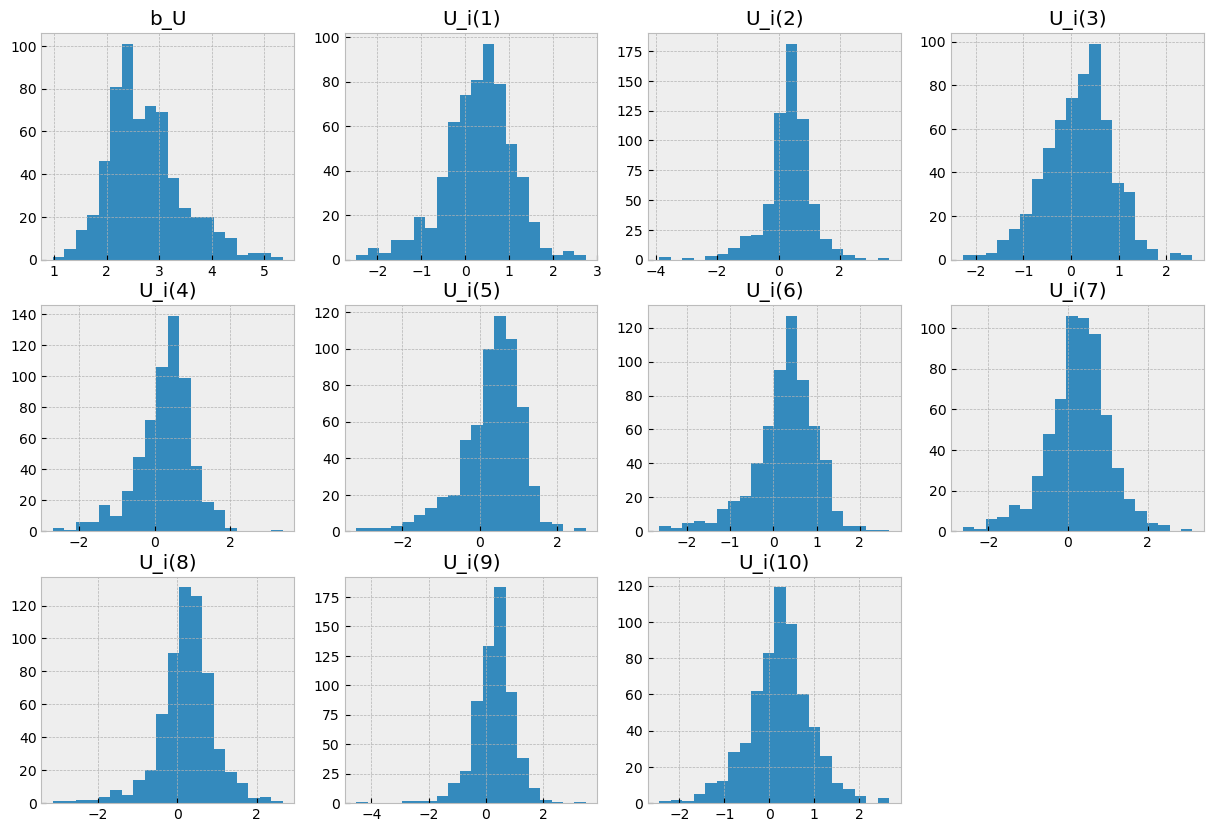

In [184]:
U_labels=np.hstack((['b_U'],np.array(['U_i('+str(i+1)+')' for i in range(k)])))

plt.figure(figsize=(15,10))
for i in range(k+1):
    plt.subplot(3,4,i+1)
    plt.hist(U[:,i], bins=20); plt.title(U_labels[i]);

As the regularization hyperparameter $\lambda$ increases, the smaller the values will be in $U_i$ (and $V_j$).

Now for the rank-$k$ matrix $V$:

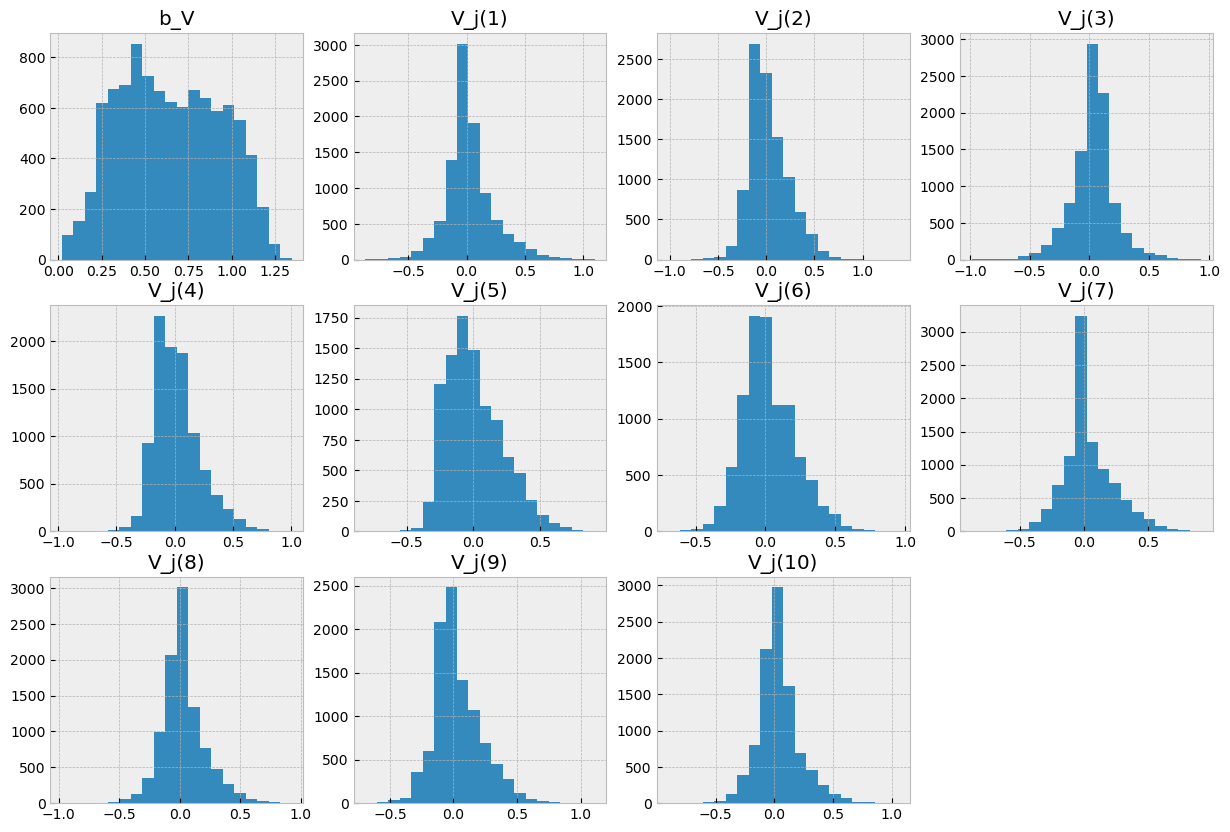

In [185]:
V_labels=np.hstack((['b_V'],np.array(['V_j('+str(j+1)+')' for j in range(k)])))

plt.figure(figsize=(15,10))
for i in range(k+1):
    plt.subplot(3,4,i+1)
    plt.hist(V[:,i], bins=20); plt.title(V_labels[i]);

Now, check the prediction for the ratings in the database:

In [189]:
mse_per_user = np.array([np.sum(Y[i,movies_per_user[i]]-
                                X[i,movies_per_user[i]])**2/len(movies_per_user[i]) for i in range(N_users)])
N_movies_per_user = np.array([len(movies_per_user[i]) for i in range(N_users)])

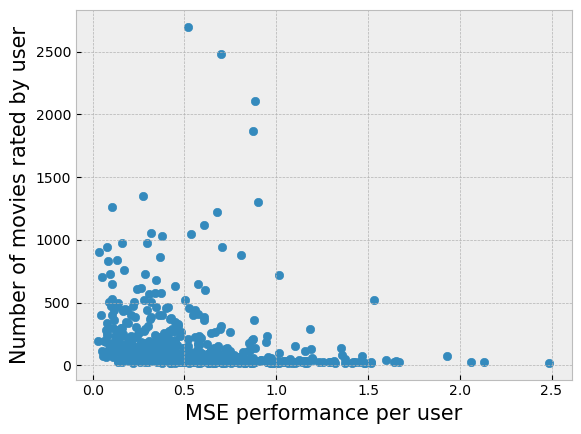

In [192]:
plt.scatter(mse_per_user, N_movies_per_user)
plt.xlabel('MSE performance per user',size=15)
plt.ylabel('Number of movies rated by user',size=15);

As expected, the smaller the number of movies the user rates, the worse the recommendation ratings will be for that user.

---

## Recommendations

Now, let's recommend movies for each user!

In [123]:
rating = 4.5 # recommend at predicted rating 4.5 or higher

In [129]:
ID = 20
print('userId: ', user_ids[ID])
movies_NOT_watched_by_user = np.setdiff1d(range(N_movies), movies_per_user[ID])
print('Movies watched: ', len(movies_per_user[ID]),'/',N_movies)
print('Average rating: ',all_movies[all_movies['userId'] == user_ids[ID]]['rating'].mean())
print('b_U = ', U[ID,0])
print('Ui = ' , U[ID,1:])

# index of recommendations at >=rating
rec_idx = np.where(Y[ID,movies_NOT_watched_by_user]>=rating)[0]
# Movie ID recommendations
rec = movie_ids[movies_NOT_watched_by_user[rec_idx]]
# predicted ratings
rec_rating = Y[ID, movies_NOT_watched_by_user[rec_idx]]

# casting as pandas dataframe for better visualization
rec_table = np.vstack((moviesRaw['title'][rec_idx].values, rec_rating)).T
# sorting based on predicted rating
rec_table[::-1].sort(axis=0)
# displaying it
df_rec = pd.DataFrame(rec_table,columns=['Recomendations', 'Predicted Rating'])
print('Number of Recommendations with rating >=',rating,': ', rec_table.shape[0])

# viewing top 20
df_rec.head(20)

userId:  21
Movies watched:  443 / 9724
Average rating:  3.260722347629797
b_U =  2.8821003298917365
Ui =  [-1.1594704   0.05601165  0.74361604  0.97756277  1.80682037  0.28800781
 -1.08631069  1.30971057 -1.2229734  -1.59015815]
Number of Recommendations with rating >= 4.5 :  64


Recomendations Predicted Rating
0                 Year of the Horse (1997)              5.0
1                        Wide Awake (1998)              5.0
2       What's Eating Gilbert Grape (1993)              5.0
3   Wallace & Gromit: A Close Shave (1995)              5.0
4                          Unzipped (1995)              5.0
5                         Tom & Viv (1994)              5.0
6             There Will Come a Day (2013)              5.0
7                      Sudden Death (1995)              5.0
8                   Steel Magnolias (1989)         4.980556
9   Steam: The Turkish Bath (Hamam) (1997)         4.960451
10  Star Trek V: The Final Frontier (1989)         4.949445
11                          Species (1995)         4.939389
12                   Shower (Xizao) (1999)          4.92381
13                    Shallow Grave (1994)         4.893272
14                       Scout, The (1994)         4.876762
15                Scanner Darkly, A (2006)         4.874895
16                          Rob Roy (1995)         4.862719
17  Postman Always Rings Twice, The (1981)         4.860059
18   Pope of Greenwich Village, The (1984)         4.839965
19                 Paper Chase, The (1973)         4.832895

---

# On-Time (5 points)

Submit your assignment before the deadline.

___

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___